In [35]:
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib
#Create uv elements
uvx = UVData()
uvy = UVData()
uvpx = UVData()
uvpy = UVData()

#Create constant variables
#Variable for the speed of light, with power adjusted for desired units
c = 0.299792
#Variable for speed of light in a cable correction factor, based on Google search
f = 2./3.

#Reference lines for plotting in the graphs
diagonals = np.linspace(0,130)
zero_line = np.linspace(0,0)
cable = np.linspace(150,150)

In [36]:
# Read in the xy data file
uvx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_6.uvOCRSL.uvfits')

# Read in the yx data file
uvy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_7.uvOCRSL.uvfits')

uvpx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_1.uvOCRSL.uvfits')

uvpy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_1.uvOCRSL.uvfits')

#Create an array of antennas we want to flag
flagged_antennas = [0,2,26,50,98,136]

In [37]:
#Read in the position and antenna numbers for all antennas
antpos, ants = uvx.get_ENU_antpos()

#This function checks to see if the entered antenna number matches with a known antenna number
#If it does, the number is printed and returned to the variable that called the function
#If it does not, an error message is printed and the user is prompted to enter a new number
#The funtion is then called again to check the new number entered
#This repeats until the user enters a valid antenna number
def check_antnum(antnum):
    if np.any(antnum==ants):
        print(antnum)
        return antnum
    else:
        print 'Number entered does not correspond to a known antenna.'
        new_ant = input("Which antenna would you like to look at? Enter here: ")
        new_ant = int(new_ant)
        new_ant = check_antnum(new_ant)
        return int(new_ant)

#Ask the user to input the desired antenna
focus_ant = input("Which antenna would you like to look at? Enter here: ")
#Take the input and represent as an integer
focus_ant = int(focus_ant)
#Run a check that the number is valid
focus_ant = check_antnum(focus_ant)

Which antenna would you like to look at? Enter here: 24
24


In [38]:
def find_blin_length(index):
    #Create an array which holds the physical distance between each antenna in meters 
    blin_length = np.zeros((52,1))
    #Step through each antenna pair with the entered antenna
    for aa,ant in enumerate(ants):
        #Find the horizontal distance between the two
        x = antpos[index,0] - antpos[aa,0]
        #Find the vertical distance between the two
        y = antpos[index,1] - antpos[aa,1]
        #Find the hypotenus of the triangle
        diag = np.sqrt(x**2 + y**2)
        #Place this value into the array
        blin_length[aa] = diag
    return(blin_length)

In [39]:
def make_blin_depd_arrays(uv,keep_flags=False):
    '''
    The purpose of this function is to read in all antenna pairs
    and produce an array of the maximum amplitudes and an array
    of the corresponding delay times. 

    Parameters 
    ----------
    uv : uv data object
        Name of the uv object being used
    keep_flags : bool, optional
        If this is set to True, a zero will be inserted into the 
        amplitude array.
        If the default value is passed, then the function will continue
        and nothing will be placed into the array.
    
    Returns
    -------
    max_amp, delays : ndarrays
        The first array holds the maximum amplitudes. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
        The second array holds the corresponding delay times. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
    '''
    
    #Create the arrays to be returned
    blin_amp=[]
    delays=[]
    i=0
    
    #Create elements to hold the beginning element that is within baseline depenedence
    #and the end element
    blin_start = 471
    blin_end = 554
    
    for i,ant1 in enumerate(uv.ant_1_array):
        #Get the second antenna number using the index number
        ant2 = uv.ant_2_array[i]
        
        #Flag out dead antennas
        #If keep_flags is set to True, a zero entry will be added to the arrays
        #If keep_flags is set to False, the function continues
        if np.any(ant1==flagged_antennas) and keep_flags:
            blin_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant1==flagged_antennas):
            continue

        if np.any(ant2==flagged_antennas) and keep_flags:
            blin_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant2==flagged_antennas):
            continue
            
        # Check if the antenna numbers are equal
        #If they are, the function will continue
        #If keep_flags is also set to True, a zero entry will be added to the arrays
        #'''
        if ant1==ant2 and keep_flags:
            #print 'same antennas'
            blin_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif ant1==ant2:
            #print 'same antennas'
            continue
        #'''
        
        # Create an array to hold the night's data
        spectrum=uv.data_array[i,0,:,0]
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uv.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width))*1e9
        #Make an variable to use in max_peak and corr_delay
        vis_abs = np.abs(vis_avg_delay[blin_start:blin_end])
        # Find the maximum amplitude and put into a variable
        blin_peak = np.max(np.abs(vis_avg_delay[blin_start:blin_end]))
        if blin_peak==0:
            blin_delay = 0
        else: 
            #Find the corresponding delay
            blin_delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==blin_peak)]
        # Append the maximum amplitude array with a list of the antenna pair and the peak
        blin_amp.append([ant1,ant2,blin_peak])
        #Append the delay array with a list of the antenna pair and the time
        delays.append([ant1,ant2,blin_delay])

    #Convert to numpy arrays
    blin_amp = np.array(blin_amp)
    delays = np.array(delays)
    
    #Return the created arrays
    return blin_amp, delays;

In [40]:
def make_matrix_array(amp_array,delay_array,antnum=None,index=False):
    '''
    The purpose of this function is to correctly fill the arrays
    that will be used to plot the matrices. 
    
    Parameters
    ----------
    amp_array : ndarray
        The array holding the amplitudes
    delay_array : ndarray
        The array holding the delay times
    antnum : int, optional
        The antenna number of a specific antenna to check for. Default is none. 
    index : bool, optional
        If this is set to True, the index number for the entered antenna number
        will be returned as well. 
        
    Returns
    -------
    amp_matrix,delay_matrix : ndarrays
        The first array holds the amplitudes correctly shaped to 
        produce the matrix. 
        The second array hold the delays correctly shaped to
        produce the matrix. 
    OR
    amp_matrix,delay_matrix,indexnum,dindexnum : ndarrays, ints
        The first array holds the amplitudes correctly shaped to 
        produce the matrix. 
        The second array hold the delays correctly shaped to
        produce the matrix. 
        indexnum is the integer index number of the amplitude matrix 
        for the entered antenna. This is only returned if index is set to True.
        dindexnum is the integer index number of the delay matrix for the 
        entered antenna. This is only returned if index is set to True.
    
    '''
    #Get a list of all of the antennas used and sort them
    antennas = list(set(amp_array[:,0]))
    antennas.sort()
    #Find the number of antennas
    nants_peak = len(antennas)
    #Create arrays to index for the matrix
    amp_matrix = np.zeros((nants_peak,nants_peak))
    delay_matrix = np.zeros((nants_peak,nants_peak))
    
    #Fill the amplitude matrix array
    for ant1,ant2,peak in amp_array:
        #Get the coordinates
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #This check forces the matrix to look nice
        if index:
            if ant1==antnum:
                #print ant1,ant2
                #print peak
                amp_matrix[i,j] = peak
                indexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                #print ant1,ant2
                #print peak
                amp_matrix[j,i] = peak
                indexnum = np.argwhere(antennas==ant2)
            else:
                amp_matrix[i,j] = 0
        elif j<i:
            amp_matrix[j,i] = peak
        else:
            amp_matrix[i,j] = peak
    
    #Fill the delay matrix array
    for ant1,ant2,delay in delay_array:
        #Get the coordinate
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #This check forces the matrix to look nice
        if index:
            if ant1==antnum:
                #print ant1,ant2
                #print peak
                delay_matrix[i,j] = delay
                dindexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                #print ant1,ant2
                #print peak
                delay_matrix[j,i] = delay
                dindexnum = np.argwhere(antennas==ant2)
            else:
                delay_matrix[i,j] = 0
        elif j<i:
            delay_matrix[j,i] = delay
        else:
            delay_matrix[i,j] = delay
    
    if index:
        return amp_matrix, delay_matrix, indexnum, dindexnum;
    else:
        return amp_matrix, delay_matrix;

In [41]:
def make_blin_ind_arrays(uv,keep_flags=False):
    '''
    The purpose of this function is to read in all antenna pairs
    and produce an array of the maximum amplitudes and an array
    of the corresponding delay times. 

    Parameters 
    ----------
    uv : uv data object
        Name of the uv object being used
    keep_flags : bool, optional
        If this is set to True, a zero will be inserted into the 
        amplitude array.
        If the default value is passed, then the function will continue
        and nothing will be placed into the array.
    
    Returns
    -------
    max_amp, delays : ndarrays
        The first array holds the maximum amplitudes. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
        The second array holds the corresponding delay times. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
    '''
    
    #Create the arrays to be returned
    ind_amp=[]
    delays=[]
    
    #Create elements to hold the beginning element that is within baseline depenedence
    #and the end element
    blin_start = 471
    blin_end = 554
    
    for i,ant1 in enumerate(uv.ant_1_array):
        #Get the second antenna number using the index number
        ant2 = uv.ant_2_array[i]
        
        #Flag out dead antennas
        #If keep_flags is set to True, a zero entry will be added to the arrays
        #If keep_flags is set to False, the function continues
        if np.any(ant1==flagged_antennas) and keep_flags:
            ind_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant1==flagged_antennas):
            continue

        if np.any(ant2==flagged_antennas) and keep_flags:
            ind_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant2==flagged_antennas):
            continue
            
        # Check if the antenna numbers are equal
        #If they are, the function will continue
        #If keep_flags is also set to True, a zero entry will be added to the arrays
        #'''
        if ant1==ant2 and keep_flags:
            #print 'same antennas'
            ind_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif ant1==ant2:
            #print 'same antennas'
            continue
        #'''
        
        # Create an array to hold the night's data
        spectrum=uv.data_array[i,0,:,0]
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uv.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width))*1e9
        #Make an variable to use in max_peak and corr_delay
        below_blin = np.max(np.abs(vis_avg_delay[:blin_start]))
        above_blin = np.max(np.abs(vis_avg_delay[blin_end:]))
        if below_blin >= above_blin:
            ind_peak = below_blin
        else: ind_peak = above_blin

        if ind_peak==0:
            ind_delay = 0
        else: 
            #Find the corresponding delay
            ind_delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==ind_peak)]
        # Append the maximum amplitude array with a list of the antenna pair and the peak
        ind_amp.append([ant1,ant2,ind_peak])
        #Append the delay array with a list of the antenna pair and the time
        delays.append([ant1,ant2,ind_delay])

    #Convert to numpy arrays
    ind_amp = np.array(ind_amp)
    delays = np.array(delays)
    
    #Return the created arrays
    return ind_amp, delays;

In [42]:
def plot_matrix_array(amp_array,amp_matrix,delay_matrix,vmin,vmax,pol):
    '''
    
    Parameters
    ----------
    amp_array : ndarray
        The amplitude array that is used to get the antenna numbers
        to be used for tick marks on the graphs
    amp_matrix : ndarray
        The array of amplitudes which will be plotted as a matrix
    delay_matrix : ndarray
        The array of delays which will be plotted as a matrix
    vmin : int
        The minimum value for the delay color scale
    vmin : int
        The maximum value for the delay color scale
    pol : str
        The string polarization/orientation that will be printed
        in the graph titles    
    
    '''
    
    #Get a list of the antennas to use for tick marks
    antennas = list(set(amp_array[:,0]))
    antennas.sort()

    fig = plt.figure(figsize=(11,5))

    #Plot the amplitudes
    ax = fig.add_subplot(121)
    cax = ax.matshow(amp_matrix,norm=SymLogNorm(vmin=200,vmax=10000,linthresh=.1))#cmap='tab20c')
    fig.colorbar(cax,fraction=0.046, pad=0.04)
    plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
    plt.yticks(np.arange(45), antennas, fontsize=8)
    plt.title(pol +' Amplitude',pad=20)
    #plt.grid()

    #Plot the delays
    ax2 = fig.add_subplot(122)
    cax2 = ax2.matshow(np.abs(delay_matrix),norm=SymLogNorm(vmin=vmin,vmax=vmax,linthresh=.1))
    fig.colorbar(cax2,fraction=0.046, pad=0.04)
    plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
    plt.yticks(np.arange(45), antennas, fontsize=8)
    plt.title('Delay (ns)',pad=20)
    plt.grid()

    plt.tight_layout()
    plt.show()

In [43]:
def plot_position_array(amp_array,delay_array,index,vmin,vmax,pol):
    '''
    
    Parameters
    ----------
    amp_array : ndarray
        The amplitude array that is used as color scale for the first plot
    delay_array : ndarray
        The delay array that is used as color scale for the first plot
    vmin : int
        The minimum value for the delay color scale
    vmin : int
        The maximum value for the delay color scale
    pol : str
        The string polarization/orientation that will be printed
        in the graph titles    
    
    '''
    
    #Plot the array of antennas with color representing amplitude for xy
    plt.figure(figsize=(10,5))
    plt.subplot(121)

    #This line isn't necessary, but it helps to better format the plot
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')

    #Now we step through each antenna and plot it with the amplitude acting as color
    for aa in range(52):
        #Get the amplitude value for the current antenna pair
        color = amp_array[index,aa]
        #Convert into integer
        color = int(color)
        #Plot the antennas with the corresponding colors
        im=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in black
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    #Print the labels and color bar
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title(pol + ' antenna correlation')
    plt.axis('equal')
    plt.colorbar(im)

    #Plot the array of antennas with color representing delay time
    plt.subplot(122)

    #Again, this line isn't strictly necessary, but it helps to better format the graph
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)

    #Now we step through each antenna and plot it with the delay acting as color
    for aa in range(52):
        #Get the delay value for the current antenna pair
        dcolor = delay_array[dindex,aa]
        #Convert into integer
        dcolor = int(dcolor)
        #To help with readability, we take the absolute value of the delay time
        dcolor = np.abs(dcolor)
        #Plot the antennas with the corresponding colors
        dim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolor,norm=SymLogNorm(vmin=vmin,vmax=vmax,linthresh=.1))
    #Print the antenna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in black
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    #Print the labels
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title(pol + ' Delay correlation')
    plt.axis('equal')
    plt.colorbar(dim)

    plt.tight_layout()
    plt.show()

In [44]:
def plot_delay_position(b_amp,b_delay_dis,i_amp,i_delay_dis,bindex,iindex,pol):
    '''
    
    Parameters
    ----------
    b_amp : ndarray
        The array of amplitudes which are in the baseline dependent region
    b_delay_dis : ndarray
        The array of delays in meters for the baseline dependent amplitudes
    i_amp : ndarray
        The array of amplitudes which are outside the baseline region
    i_delay_dis : ndarray
        The array of delays in meters for the baseline independent amps
    bindex : int
        The index within the baseline dependent arrays
    iindex : int
        The index within the baseline independent arrays
    pol : str
        The string polarization/orientation that will be printed
        in the graph titles    
    
    '''
    blin_length = find_blin_length(bindex)
    
    plt.figure(figsize=(10,5))

    #Plot the array of antennas with color representing amplitude for xy
    plt.subplot(121)
    for aa,ant in enumerate(ants):
        #Get the amplitude value for the current antenna pair
        color = b_amp[bindex,aa]
        #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
        if ant==focus_ant:
            plt.scatter(0,0,marker='.',color='black',s=2000)
        #Skip flagged antennas
        #I also flag antenna 84 because it throws off the scale of the graph because one dipole is dead
        elif np.any(ant==flagged_antennas): continue
        #Now we plot the remaining antennas with the color representing the amplitude
        #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
        #The y coordinate corresponds to the delay distance found by the antennas
        else: im=plt.scatter(blin_length[aa,0],b_delay_dis[index,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        #If the current antenna is the focus antenna, manually print number at 0,0
        if ant==focus_ant: 
            plt.text(0,0,ants[aa],color='w',va='center',ha='center')
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Print the remaining antenna numbers at the correct coordinates
        else: plt.text(blin_length[aa,0],b_delay_dis[index,aa],ants[aa],color='w',va='center',ha='center')
    #Plot lines on the diagonal and the zero
    plt.plot(diagonals,-diagonals)
    plt.plot(diagonals,diagonals)
    plt.plot(diagonals,zero_line)
    #Print labels
    plt.xlabel('Physical Distance (m)')
    plt.ylabel('Delay distance (m)')
    plt.title(pol + ' antenna correlation, baseline dependent')
    plt.colorbar(im, label='Amplitude')

    plt.subplot(122)
    #Plot the array of antennas with color representing amplitude for xy
    for aa,ant in enumerate(ants):
        #Get the amplitude value for the current antenna pair
        color = i_amp[iindex,aa]
        #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
        if ant==focus_ant:
            plt.scatter(0,0,marker='.',color='black',s=2000)
        #Skip flagged antennas
        #I also flag antenna 84 because it throws off the scale of the graph because one dipole is dead
        elif np.any(ant==flagged_antennas): continue
        #Now we plot the remaining antennas with the color representing the amplitude
        #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
        #The y coordinate corresponds to the delay distance found by the antennas
        else: indim=plt.scatter(blin_length[aa,0],i_delay_dis[iindex,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        #If the current antenna is the focus antenna, manually print number at 0,0
        if ant==focus_ant: 
            plt.text(0,0,ants[aa],color='w',va='center',ha='center')
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Print the remaining antenna numbers at the correct coordinates
        else: plt.text(blin_length[aa,0],i_delay_dis[iindex,aa],ants[aa],color='w',va='center',ha='center')
    #Plot lines on the diagonal and the zero
    plt.plot(diagonals,-diagonals)
    plt.plot(diagonals,diagonals)
    plt.plot(diagonals,cable)
    plt.plot(diagonals,-cable)
    #Print labels
    plt.xlabel('Physical Distance (m)')
    plt.ylabel('Delay distance (m)')
    plt.title(pol + ' antenna correlation, baseline independent')
    plt.colorbar(indim, label='Amplitude')

    plt.tight_layout()
    plt.show()

Ok, so the array has 1024 elements, and the delay times go from -5120 ns to 5110 ns. This corresponds to distance of -1.5e3 m to 1.5e3 m. 

The center element is 512. 

Baselines are ~15 m, or ~50 ns. If we have a window of 30 m to look for a baseline, that is ~100 ns. Going in each direction, we need the center 20 elements (because it counts by tens and so instead of 200 elements, it is only 20). 

However, we aren't just looking at baselines of 15 m, because we are also looking at antennas that are several baselines away. Our longest baseline is ~120m away, or 400ns. 

So for baseline dependency, we want to look at the elements on either side of 0 between, let's say, -410 and 410. This looks like: [471:554] 

To look at every that is not baseline dependent, we get: [:471],[554:]

We are going to use modifed versions of the make_max_arrays from ant_matrix. 

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


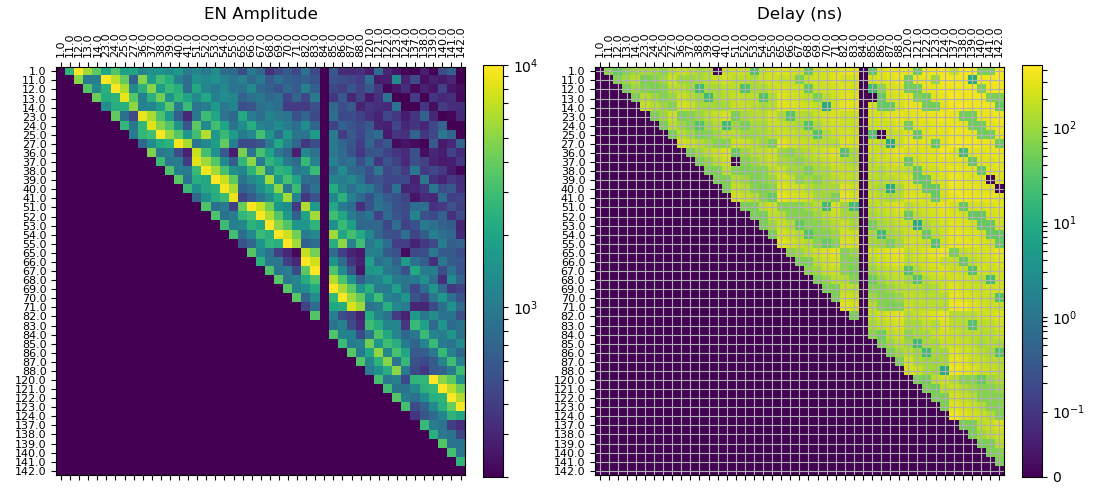

In [45]:
blin_amp_xy,blin_delay_xy = make_blin_depd_arrays(uvx)

print blin_delay_xy.shape
print blin_amp_xy.shape

blin_amp_matrix_xy,blin_delay_matrix_xy=make_matrix_array(blin_amp_xy,blin_delay_xy)

print blin_amp_matrix_xy.shape
print blin_delay_matrix_xy.shape

plot_matrix_array(blin_amp_xy,blin_amp_matrix_xy,blin_delay_matrix_xy,0,450,'EN')

<IPython.core.display.Javascript object>


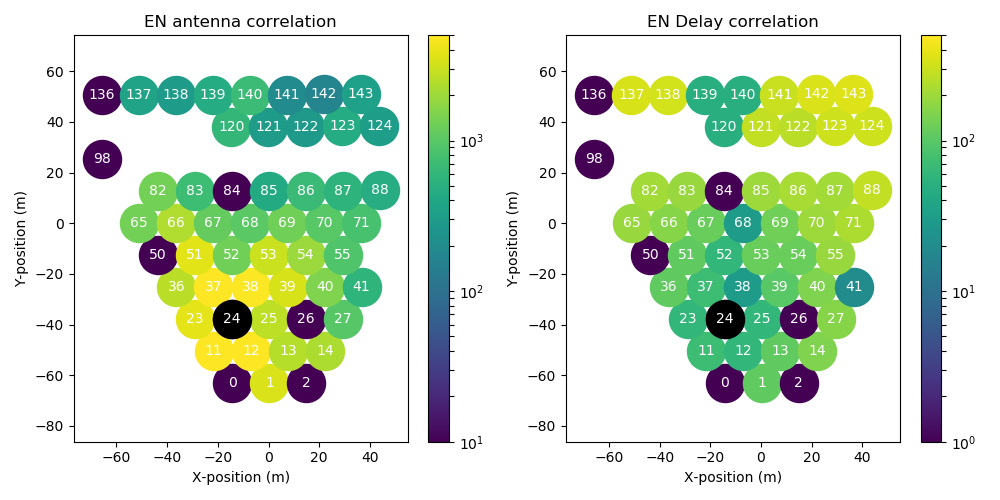

In [46]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_xy, full_ant_delay_xy = make_blin_depd_arrays(uvx, keep_flags=True)
blin_ants_amp_xy, blin_ants_delay_xy, index, dindex = make_matrix_array(full_ant_amp_xy, full_ant_delay_xy, antnum=focus_ant, index=True)

plot_position_array(blin_ants_amp_xy,blin_ants_delay_xy,index,1,500,'EN')

We've been able to isolate the amplitudes that are baseline dependent, now it's time to look at everything else. 

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


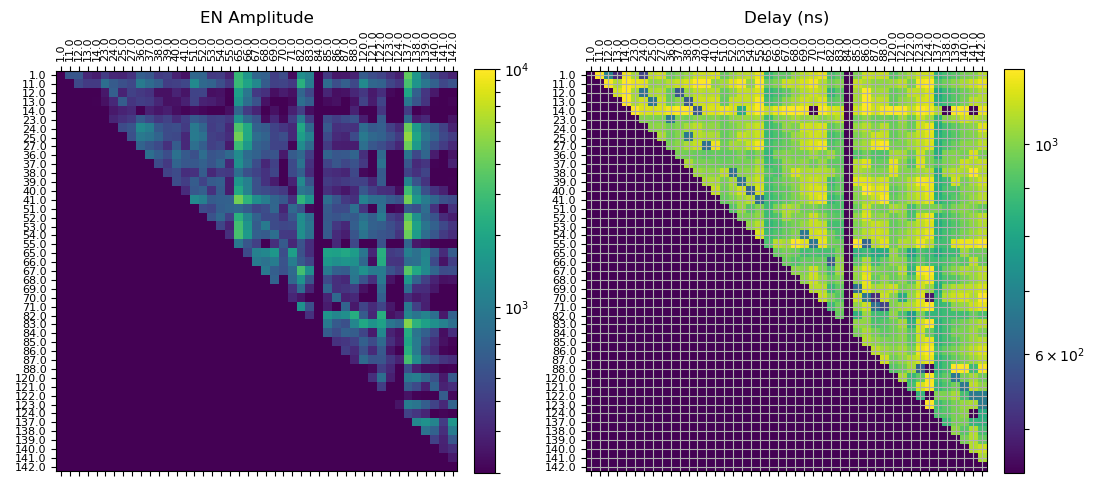

In [47]:
ind_amp_xy,ind_delay_xy = make_blin_ind_arrays(uvx)

print ind_delay_xy.shape
#print blin_delay_xy
print ind_amp_xy.shape

ind_amp_matrix_xy,ind_delay_matrix_xy=make_matrix_array(ind_amp_xy,ind_delay_xy)

print ind_amp_matrix_xy.shape
print ind_delay_matrix_xy.shape

plot_matrix_array(ind_amp_xy,ind_amp_matrix_xy,ind_delay_matrix_xy,vmin=450,vmax=1200,pol='EN')

<IPython.core.display.Javascript object>


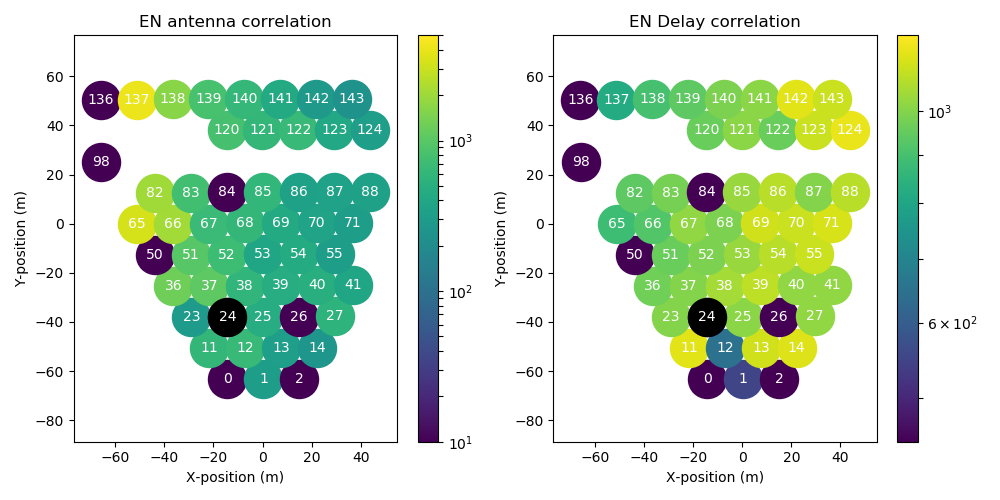

In [73]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_xy, full_ant_ind_delay_xy = make_blin_ind_arrays(uvx, keep_flags=True)
ind_ants_amp_xy, ind_ants_delay_xy, index_ind, dindex_ind = make_matrix_array(full_ant_ind_amp_xy, full_ant_ind_delay_xy, antnum=focus_ant, index=True)

plot_position_array(ind_ants_amp_xy,ind_ants_delay_xy,index_ind,vmin=450,vmax=1200,pol='EN')

<IPython.core.display.Javascript object>


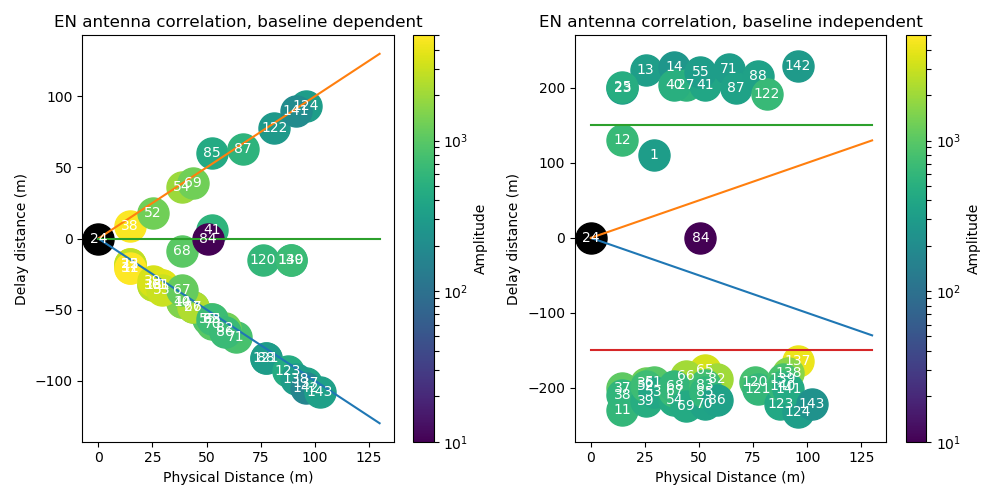

In [49]:
#Create an array which holds the delay times in meters
blin_delay_distance = blin_ants_delay_xy * c
#Create an array which holds the delay times in meters
ind_delay_distance = ind_ants_delay_xy * c * f

plot_delay_position(blin_ants_amp_xy,blin_delay_distance,ind_ants_amp_xy,ind_delay_distance,index,index_ind,'EN')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


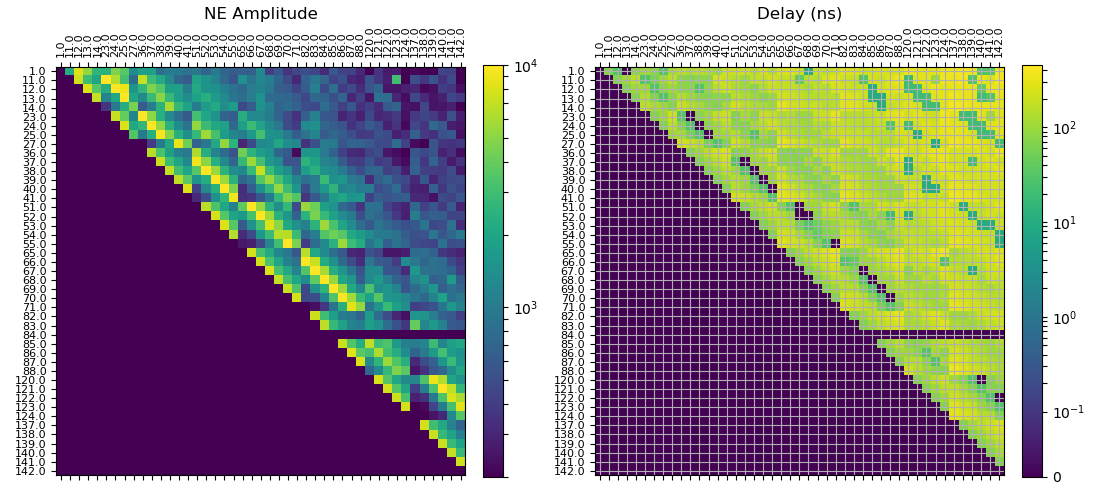

In [50]:
blin_amp_yx,blin_delay_yx = make_blin_depd_arrays(uvy)

print blin_delay_yx.shape
#print blin_delay_xy
print blin_amp_yx.shape

blin_amp_matrix_yx,blin_delay_matrix_yx=make_matrix_array(blin_amp_yx,blin_delay_yx)

print blin_amp_matrix_yx.shape
print blin_delay_matrix_yx.shape

plot_matrix_array(blin_amp_yx,blin_amp_matrix_yx,blin_delay_matrix_yx,vmin=0,vmax=450,pol='NE')

<IPython.core.display.Javascript object>


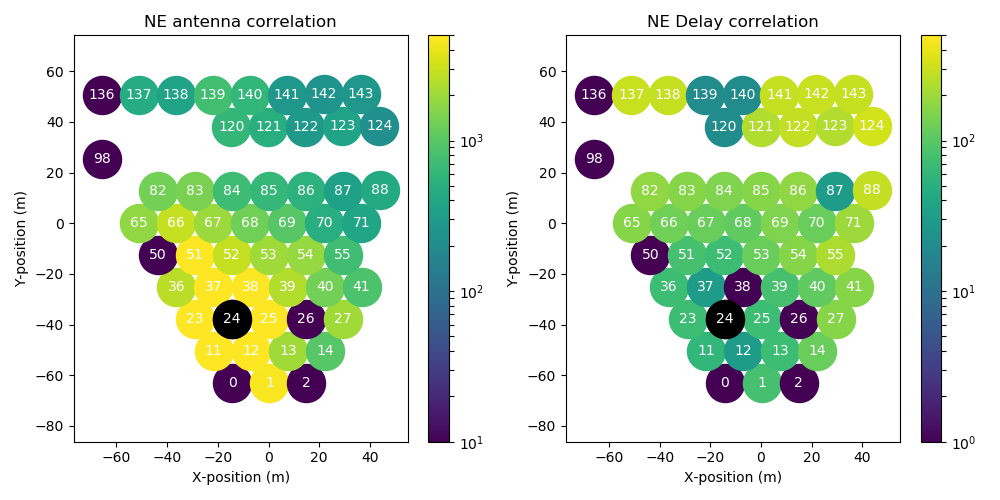

In [71]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_yx, full_ant_delay_yx = make_blin_depd_arrays(uvy, keep_flags=True)
blin_ants_amp_yx, blin_ants_delay_yx, indeyx, dindeyx = make_matrix_array(full_ant_amp_yx, full_ant_delay_yx, antnum=focus_ant, index=True)

plot_position_array(blin_ants_amp_yx,blin_ants_delay_yx,indeyx,vmin=1,vmax=500,pol='NE')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


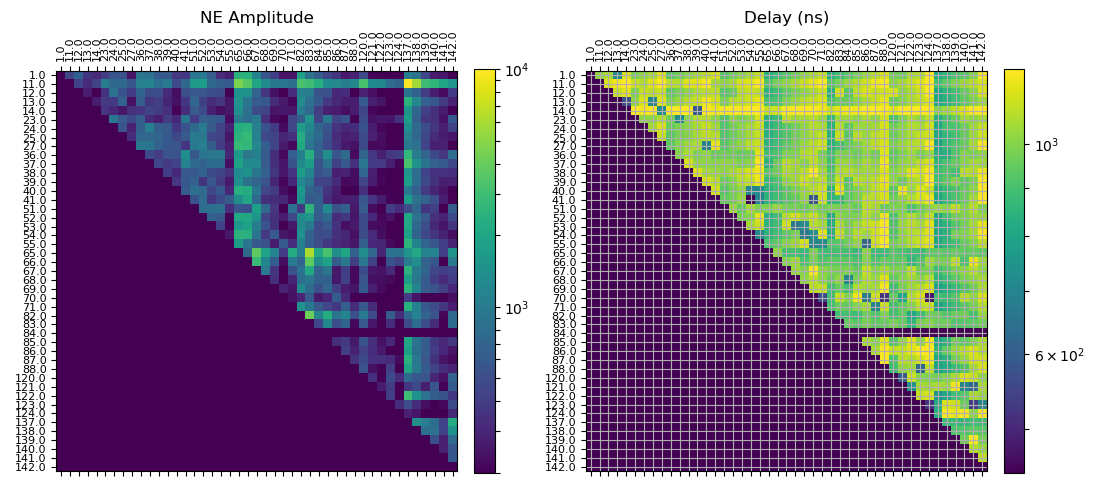

In [52]:
ind_amp_yx,ind_delay_yx = make_blin_ind_arrays(uvy)

print ind_delay_yx.shape
print ind_amp_yx.shape

ind_amp_matrix_yx,ind_delay_matrix_yx=make_matrix_array(ind_amp_yx,ind_delay_yx)

print ind_amp_matrix_yx.shape
print ind_delay_matrix_yx.shape

plot_matrix_array(ind_amp_yx,ind_amp_matrix_yx,ind_delay_matrix_yx,vmin=450,vmax=1200,pol='NE')

<IPython.core.display.Javascript object>


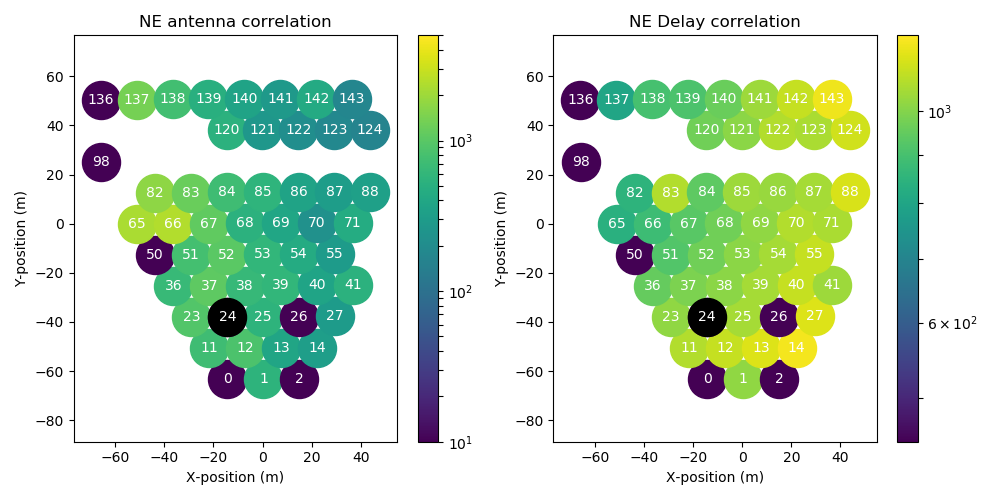

In [70]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_yx, full_ant_ind_delay_yx = make_blin_ind_arrays(uvy, keep_flags=True)
ind_ants_amp_yx, ind_ants_delay_yx, indeyx_ind, dindeyx_ind = make_matrix_array(full_ant_ind_amp_yx, full_ant_ind_delay_yx, antnum=focus_ant, index=True)

plot_position_array(ind_ants_amp_yx,ind_ants_delay_yx,indeyx_ind,vmin=450,vmax=1200,pol='NE')

<IPython.core.display.Javascript object>


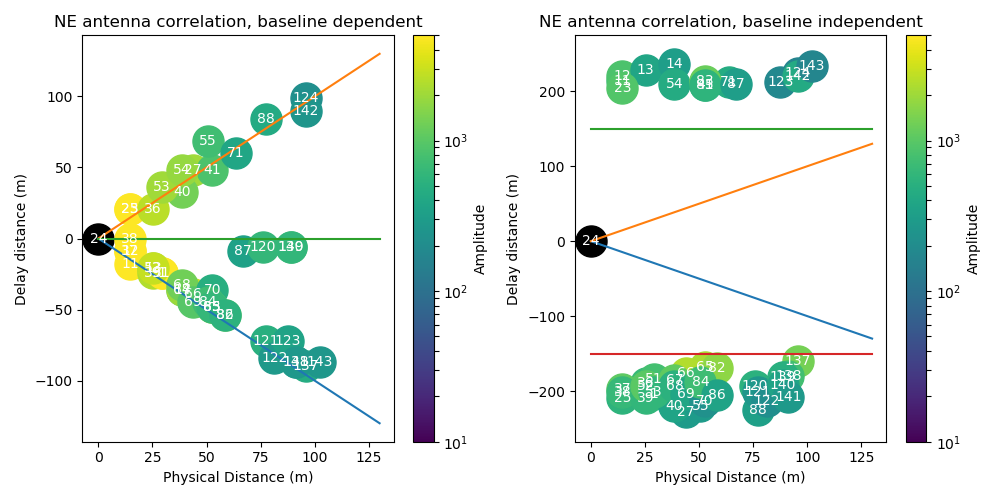

In [54]:
#Create an array which holds the delay times in meters
blin_delay_distance_yx = blin_ants_delay_yx * c

#Create an array which holds the delay times in meters
ind_delay_distance_yx = ind_ants_delay_yx * c * f

plot_delay_position(blin_ants_amp_yx,blin_delay_distance_yx,ind_ants_amp_yx,ind_delay_distance_yx,indeyx,indeyx_ind,'NE')


(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


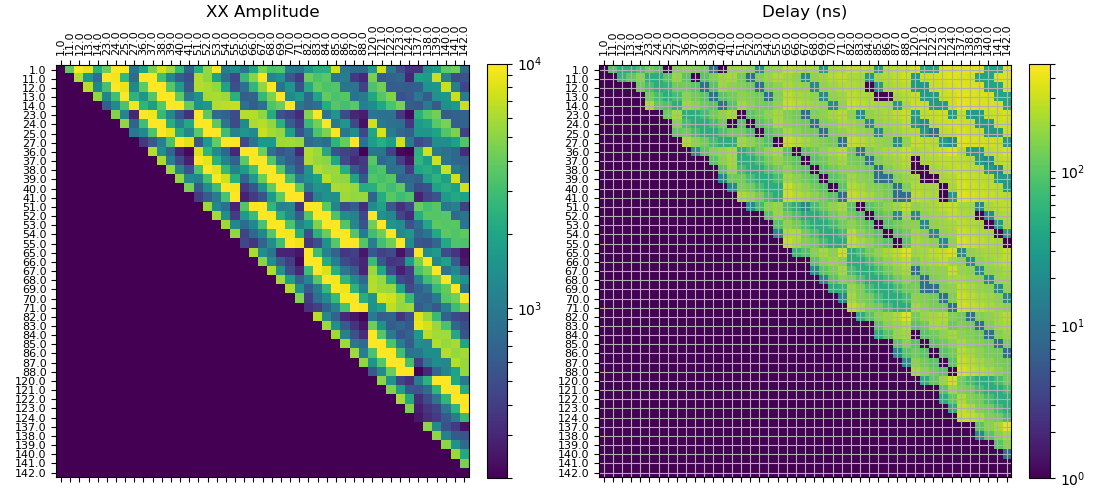

In [55]:
blin_amp_xx,blin_delay_xx = make_blin_depd_arrays(uvpx)

print blin_delay_xx.shape
print blin_amp_xx.shape

blin_amp_matrix_xx,blin_delay_matrix_xx=make_matrix_array(blin_amp_xx,blin_delay_xx)

print blin_amp_matrix_xx.shape
print blin_delay_matrix_xx.shape

plot_matrix_array(blin_amp_xx,blin_amp_matrix_xx,blin_delay_matrix_xx,vmin=1,vmax=500,pol='XX')

<IPython.core.display.Javascript object>


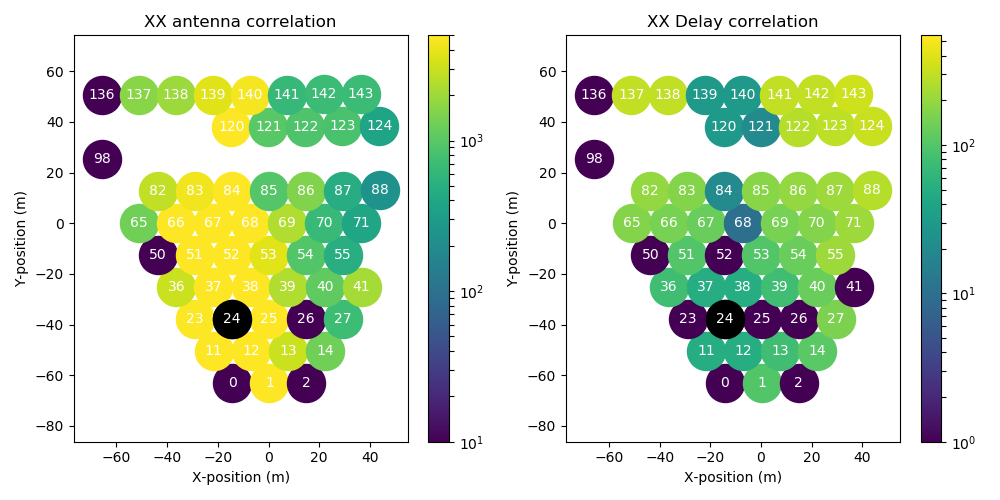

In [56]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_xx, full_ant_delay_xx = make_blin_depd_arrays(uvpx, keep_flags=True)
blin_ants_amp_xx, blin_ants_delay_xx, indexx, dindexx = make_matrix_array(full_ant_amp_xx, full_ant_delay_xx, antnum=focus_ant, index=True)

plot_position_array(blin_ants_amp_xx,blin_ants_delay_xx,indexx,vmin=1,vmax=550,pol='XX')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


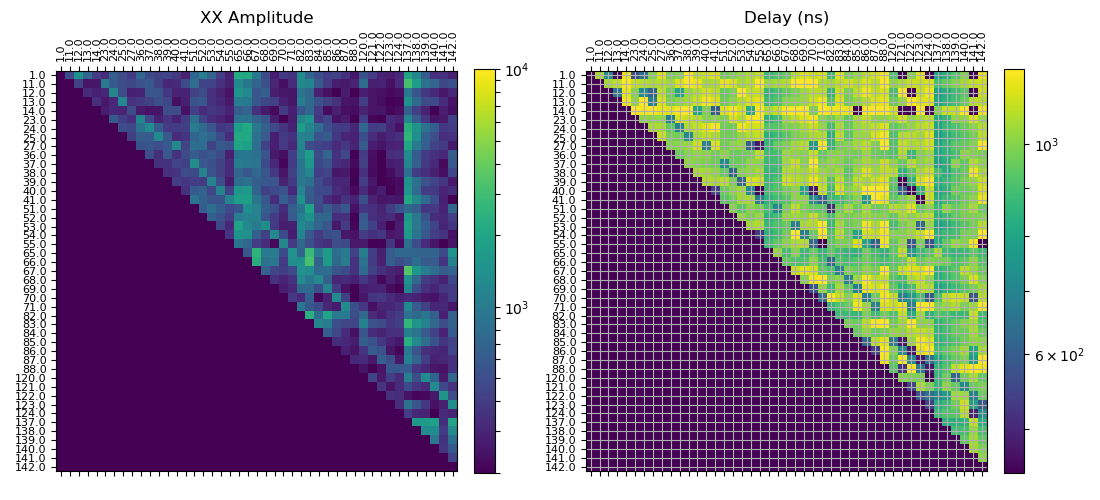

In [57]:
ind_amp_xx,ind_delay_xx = make_blin_ind_arrays(uvpx)

print ind_delay_xx.shape
print ind_amp_xx.shape

ind_amp_matrix_xx,ind_delay_matrix_xx=make_matrix_array(ind_amp_xx,ind_delay_xx)

print ind_amp_matrix_xx.shape
print ind_delay_matrix_xx.shape

plot_matrix_array(ind_amp_xx,ind_amp_matrix_xx,ind_delay_matrix_xx,vmin=450,vmax=1200,pol='XX')

<IPython.core.display.Javascript object>


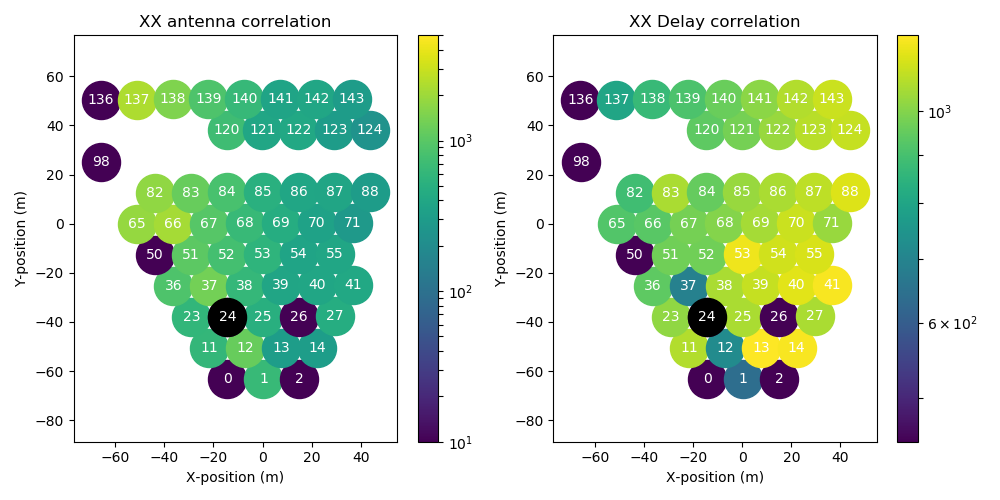

In [68]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_xx, full_ant_ind_delay_xx = make_blin_ind_arrays(uvpx, keep_flags=True)
ind_ants_amp_xx, ind_ants_delay_xx, indexx_ind, dindexx_ind = make_matrix_array(full_ant_ind_amp_xx, full_ant_ind_delay_xx, antnum=focus_ant, index=True)

plot_position_array(ind_ants_amp_xx,ind_ants_delay_xx,indexx_ind,vmin=450,vmax=1200,pol='XX')

<IPython.core.display.Javascript object>


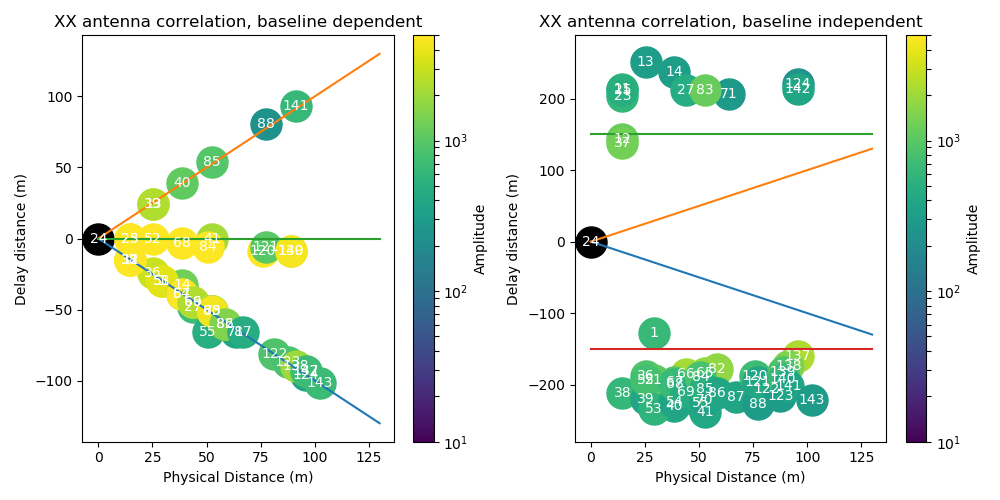

In [59]:
#Create an array which holds the delay times in meters
blin_delay_distance_xx = blin_ants_delay_xx * c

#Create an array which holds the delay times in meters
ind_delay_distance_xx = ind_ants_delay_xx * c * f

plot_delay_position(blin_ants_amp_xx,blin_delay_distance_xx,ind_ants_amp_xx,ind_delay_distance_xx,indexx,indexx_ind,'XX')


(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


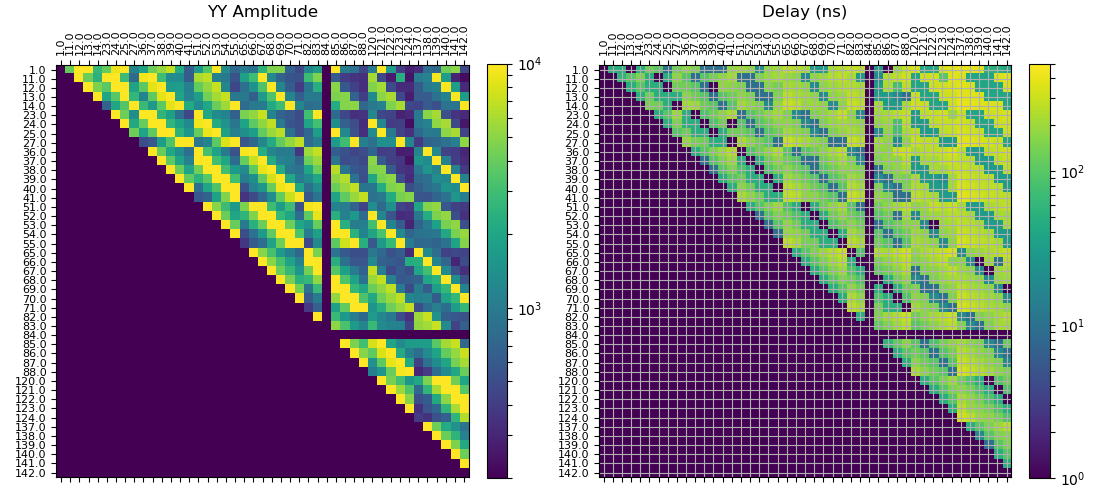

In [60]:
blin_amp_yy,blin_delay_yy = make_blin_depd_arrays(uvpy)

print blin_delay_yy.shape
print blin_amp_yy.shape

blin_amp_matrix_yy,blin_delay_matrix_yy=make_matrix_array(blin_amp_yy,blin_delay_yy)

print blin_amp_matrix_yy.shape
print blin_delay_matrix_yy.shape

plot_matrix_array(blin_amp_yy,blin_amp_matrix_yy,blin_delay_matrix_yy,vmin=1,vmax=500,pol='YY')

<IPython.core.display.Javascript object>


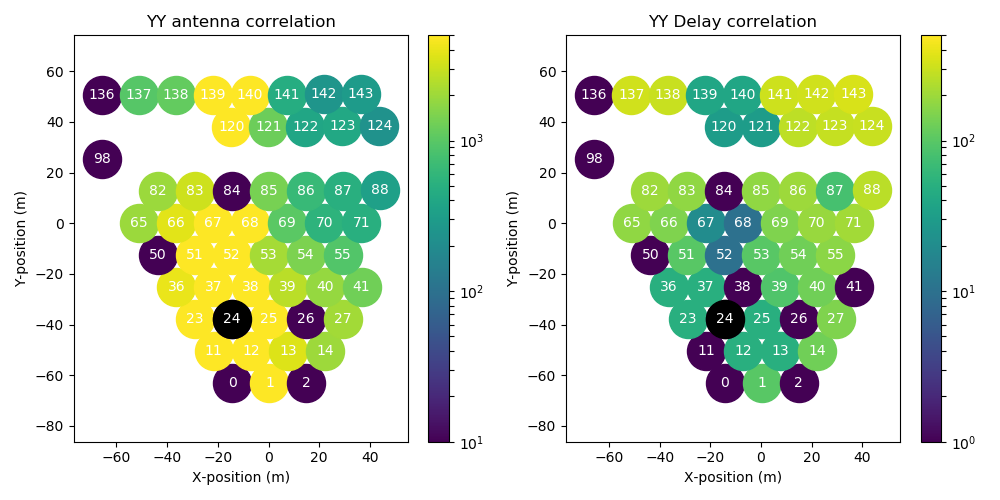

In [67]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_yy, full_ant_delay_yy = make_blin_depd_arrays(uvpy, keep_flags=True)
blin_ants_amp_yy, blin_ants_delay_yy, indeyy, dindeyy = make_matrix_array(full_ant_amp_yy, full_ant_delay_yy, antnum=focus_ant, index=True)

plot_position_array(blin_ants_amp_yy,blin_ants_delay_yy,indeyy,vmin=1,vmax=500,pol='YY')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


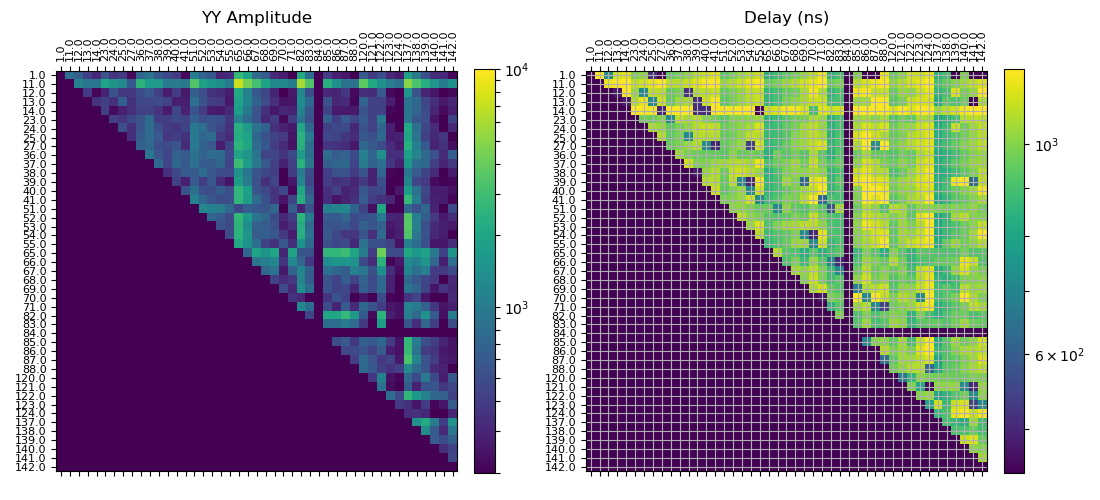

In [62]:
ind_amp_yy,ind_delay_yy = make_blin_ind_arrays(uvpy)

print ind_delay_yy.shape
print ind_amp_yy.shape

ind_amp_matrix_yy,ind_delay_matrix_yy=make_matrix_array(ind_amp_yy,ind_delay_yy)

print ind_amp_matrix_yy.shape
print ind_delay_matrix_yy.shape

plot_matrix_array(ind_amp_yy,ind_amp_matrix_yy,ind_delay_matrix_yy,vmin=450,vmax=1200,pol='YY')

<IPython.core.display.Javascript object>


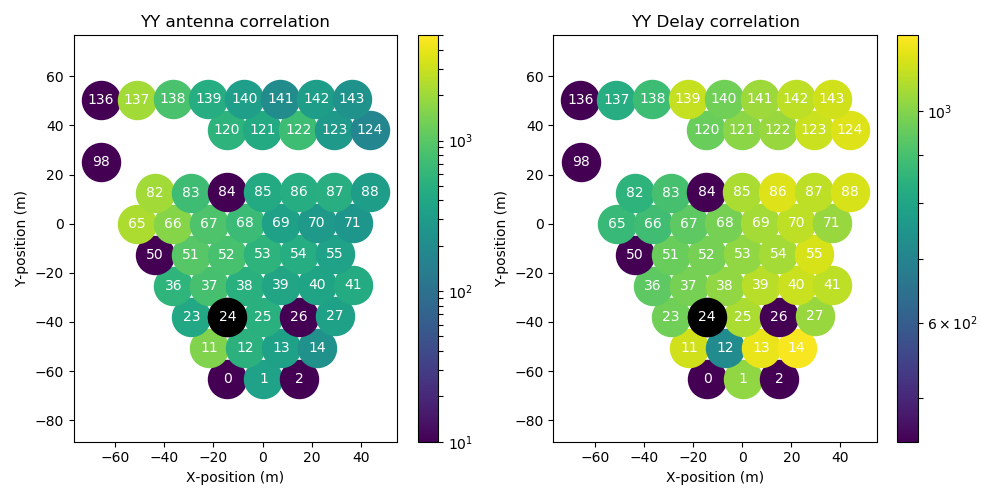

In [66]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_yy, full_ant_ind_delay_yy = make_blin_ind_arrays(uvpy, keep_flags=True)
ind_ants_amp_yy, ind_ants_delay_yy, indeyy_ind, dindeyy_ind = make_matrix_array(full_ant_ind_amp_yy, full_ant_ind_delay_yy, antnum=focus_ant, index=True)

plot_position_array(ind_ants_amp_yy,ind_ants_delay_yy,indeyy_ind,vmin=450,vmax=1200,pol='YY')

<IPython.core.display.Javascript object>


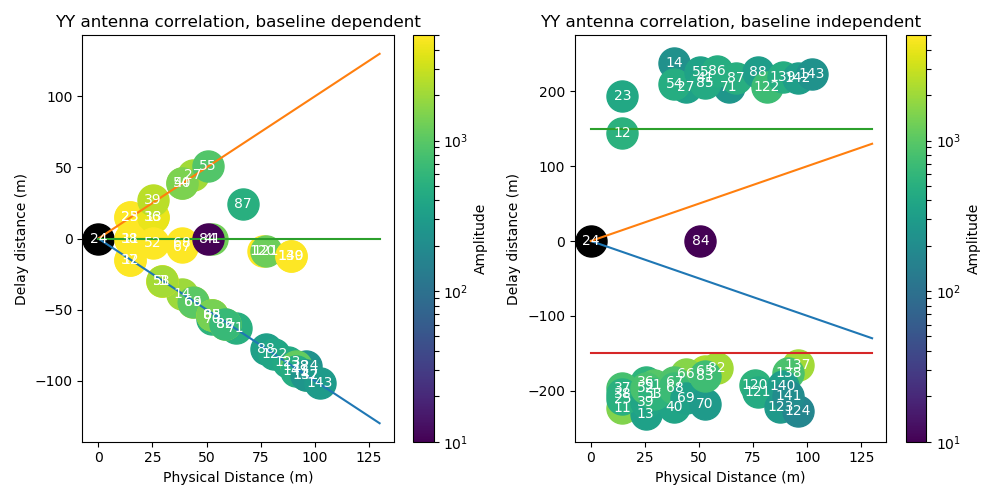

In [64]:
#Create an array which holds the delay times in meters
blin_delay_distance_yy = blin_ants_delay_yy * c

#Create an array which holds the delay times in meters
ind_delay_distance_yy = ind_ants_delay_yy * c * f

plot_delay_position(blin_ants_amp_yy,blin_delay_distance_yy,ind_ants_amp_yy,ind_delay_distance_yy,indeyy,indeyy_ind,'YY')
